In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1) 

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([5, 9, 4, 6, 0, 3, 7, 1, 2]), tensor([10,  8]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) 
linear_model(t_un_val)

tensor([[-3.6012],
        [-2.4921]], grad_fn=<AddmmBackward>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.5546]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([0.1920], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-0.3625], grad_fn=<AddBackward0>)

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.3625],
        [-0.3625],
        [-0.3625],
        [-0.3625],
        [-0.3625],
        [-0.3625],
        [-0.3625],
        [-0.3625],
        [-0.3625],
        [-0.3625]], grad_fn=<AddmmBackward>)

In [11]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
    )

In [12]:
linear_model.parameters()

<generator object Module.parameters at 0x7f25bacc7eb0>

In [13]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.6129]], requires_grad=True),
 Parameter containing:
 tensor([-0.3051], requires_grad=True)]

In [22]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print('Epoch:{}, Training loss{:.4f}, Validaton loss{:.4f}'.format(epoch, loss_train.item(), loss_val.item()))

In [23]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(n_epochs = 3000, optimizer = optimizer, model = linear_model, loss_fn=nn.MSELoss(),
             t_u_train=t_un_train, t_u_val=t_un_val, t_c_train=t_c_train, t_c_val=t_c_val)

print(linear_model.weight)
print(linear_model.bias)

Epoch:1, Training loss199.6185, Validaton loss270.0771
Epoch:1000, Training loss3.0491, Validaton loss7.5386
Epoch:2000, Training loss2.4501, Validaton loss5.7210
Epoch:3000, Training loss2.4376, Validaton loss5.4841
Parameter containing:
tensor([[5.2243]], requires_grad=True)
Parameter containing:
tensor([-16.4575], requires_grad=True)


In [24]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [26]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [27]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [29]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [30]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [31]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.2358], requires_grad=True)

In [33]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)


training_loop(n_epochs = 5000, optimizer = optimizer, model = seq_model, loss_fn=nn.MSELoss(),
             t_u_train=t_un_train, t_u_val=t_un_val, t_c_train=t_c_train, t_c_val=t_c_val)

print('output:', seq_model(t_un_val))
print('answer:', t_c_val)
print('hidden:', seq_model.hidden_linear.weight.grad)

Epoch:1, Training loss160.9313, Validaton loss217.5932
Epoch:1000, Training loss5.4139, Validaton loss5.0651
Epoch:2000, Training loss3.7512, Validaton loss3.4343
Epoch:3000, Training loss2.1713, Validaton loss1.5991
Epoch:4000, Training loss1.9476, Validaton loss1.5848
Epoch:5000, Training loss1.9142, Validaton loss1.6966
output: tensor([[20.5553],
        [ 7.7877]], grad_fn=<AddmmBackward>)
answer: tensor([[21.],
        [ 6.]])
hidden: tensor([[-0.0059],
        [ 0.0051],
        [ 0.0094],
        [ 0.0065],
        [ 0.0102],
        [ 0.0055],
        [ 0.0060],
        [ 0.0085]])


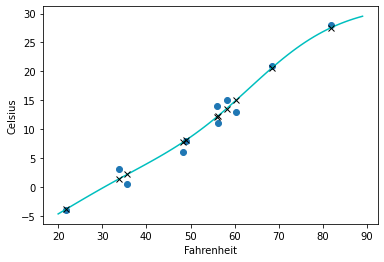

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure()

plt.xlabel('Fahrenheit')
plt.ylabel('Celsius')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [42]:
torch.arange(20., 90.)

tensor([20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.,
        33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45.,
        46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58.,
        59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71.,
        72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83., 84.,
        85., 86., 87., 88., 89.])